In [40]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install torch
!pip install scikit-learn
!pip install torchvision
!pip install tqdm
!pip3 install torch torchvision torchaudio


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip


In [42]:
!pip3 install torch_directml

ERROR: Could not find a version that satisfies the requirement torch_directml (from versions: none)
ERROR: No matching distribution found for torch_directml

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip


In [493]:
import torch
# import torch_directml
# dml = torch_directml.device()
# print(dml)
# tensor1 = torch.tensor([1]).to(dml) # Note that dml is a variable, not a string!
# tensor2 = torch.tensor([2]).to(dml)
# dml_algebra = tensor1 + tensor2
# print(dml_algebra.item())


In [494]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import f1_score
from torchvision import datasets, transforms
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from sklearn.model_selection import GridSearchCV
from torch.utils.data import Dataset, Subset
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from sklearn.base import BaseEstimator, ClassifierMixin

Hyperparameters

In [495]:
class Hparams:
    def __init__(self, train_batch_size=64, test_batch_size=64, learning_rate=0.001, num_epochs = 10, val_split=0.2, test_split=0.1, model_path='saved_model', dataset_path='./Data_detection'):
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.val_split = val_split
        self.test_split = test_split
        self.model_path = model_path #removed this in the contructor arguments as well
        self.dataset_path = dataset_path

Dataset Loader

In [496]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, subset = None, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
            mean = torch.mean(x)
            std = torch.std(x)
        return x, mean, std, y

    def __len__(self):
        return len(self.subset)

In [497]:
def get_transforms():
    transform = transforms.Compose([
        transforms.Resize((248, 248)),
        transforms.ToTensor(),
    ])
    return transform

In [498]:
def get_transforms_train():
    transform = transforms.Compose([
        transforms.Resize((248, 248)),
        transforms.RandomAffine(0, translate=None, scale= (0.9, 1.05), shear=None),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor()
    ])
    return transform

In [499]:
def get_sample_weights(dataset, train_dataset):

    # Code taken from:
    #     https://www.maskaravivek.com/post/pytorch-weighted-random-sampler/
    y_train_indices = train_dataset.indices
    print(train_dataset.indices)
    print(dataset.targets)
    y_train = [dataset.targets[i] for i in y_train_indices]

    class_sample_counts = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

    weights = 1. / class_sample_counts
    sample_weights = np.array([weights[t] for t in y_train])
    sample_weights = torch.from_numpy(sample_weights)

    return sample_weights

In [500]:
def get_data_loaders(hparams):
    # Loading the dataset
    dataset = datasets.ImageFolder(hparams.dataset_path,
                                   transform=transforms.Compose([transforms.Grayscale()]))

    # Splitting dataset into train, validation and test partitions.
    proportions = [(1 - hparams.val_split - hparams.test_split), hparams.val_split, hparams.test_split]
    lengths = [int(p * len(dataset)) for p in proportions]
    lengths[-1] = len(dataset) - sum(lengths[:-1])

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths)

    print(type(train_dataset))

    print(type(train_dataset[0][0]))

    print(f'train size: {lengths[0]}, val size: {lengths[1]}, test size: {lengths[2]}')

    data_transforms = {
        'train': get_transforms_train(),
        'test': get_transforms()
    }

    # Using WeightedRandomSampler to overcome unbalance problem
    sample_weights = get_sample_weights(dataset, train_dataset)
    train_sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weights.type('torch.DoubleTensor'), len(sample_weights))

    train_dataset = CustomDataset(train_dataset, transform=data_transforms['train'])
    val_dataset = CustomDataset(val_dataset, transform=data_transforms['test'])
    test_dataset = CustomDataset(test_dataset, transform=data_transforms['test'])

    plt.imshow(train_dataset[0][0].moveaxis(0,2), cmap='gray') 

    # Creating loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams.train_batch_size, sampler=train_sampler, drop_last=True, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams.train_batch_size, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hparams.test_batch_size)

    return train_loader, val_loader, test_loader

In [501]:
from sklearn.model_selection import train_test_split

def get_split_dataset_loaders(hparams):

    folder_path = './Data_detection/Demented'

    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)

    image_names = [file for file in file_list]

    for i in range (len(image_names)):
        image_names[i] = image_names[i][:-14]

    uniqueID = pd.Series(image_names)
    uniqueID = uniqueID.unique()

    # Proportions you want to split into (e.g., 60% train, 20% validation, 20% test)
    train_proportion = 1 - hparams.val_split - hparams.test_split
    validation_proportion = hparams.val_split
    test_proportion = hparams.test_split

    # Perform the random split
    train_ID, temp_ID = train_test_split(uniqueID, train_size=train_proportion, random_state=42)
    validation_ID, test_ID = train_test_split(temp_ID, train_size=validation_proportion / (validation_proportion + test_proportion), random_state=42)

    dataset = datasets.ImageFolder(hparams.dataset_path,
                                   transform=transforms.Compose([transforms.Grayscale()]))

    index = 0
    location_change = [0]
    for i in range(len(dataset)):
        if (dataset[i][1] != index):
            location_change.append(i)
            index += 1

    train_index = []
    for i in range (len(train_ID)):
        for ii in range (len(file_list)):
            if (train_ID[i] in file_list[ii]):
                train_index.append(ii+location_change[0])
            
    val_index = []
    for i in range (len(validation_ID)):
        for ii in range (len(file_list)):
            if (validation_ID[i] in file_list[ii]):
                val_index.append(ii+location_change[0])

    test_index = []
    for i in range (len(test_ID)):
        for ii in range (len(file_list)):
            if (test_ID[i] in file_list[ii]):
                test_index.append(ii+location_change[0])


    folder_path = './Data_detection/NonDemented'

    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)

    image_names = [file for file in file_list]

    for i in range (len(image_names)):
        image_names[i] = image_names[i][:-14]

    uniqueID = pd.Series(image_names)
    uniqueID = uniqueID.unique()

    # Perform the random split
    train_ID, temp_ID = train_test_split(uniqueID, train_size=train_proportion, random_state=42)
    validation_ID, test_ID = train_test_split(temp_ID, train_size=validation_proportion / (validation_proportion + test_proportion), random_state=42)

    for i in range (len(train_ID)):
        for ii in range (len(file_list)):
            if (train_ID[i] in file_list[ii]):
                train_index.append(ii+location_change[1])
            
    for i in range (len(validation_ID)):
        for ii in range (len(file_list)):
            if (validation_ID[i] in file_list[ii]):
                val_index.append(ii+location_change[1])

    for i in range (len(test_ID)):
        for ii in range (len(file_list)):
            if (test_ID[i] in file_list[ii]):
                test_index.append(ii+location_change[1])




    train_dataset = Subset(dataset, train_index)
    val_dataset = Subset(dataset, val_index)
    test_dataset =  Subset(dataset, test_index)

    data_transforms = {
        'train': get_transforms_train(),
        'test': get_transforms()
    }

    # Using WeightedRandomSampler to overcome unbalance problem
    sample_weights = get_sample_weights(dataset, train_dataset)
    train_sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weights.type('torch.DoubleTensor'), len(sample_weights))

    train_dataset = CustomDataset(train_dataset, transform=data_transforms['train'])
    val_dataset = CustomDataset(val_dataset, transform=data_transforms['test'])
    test_dataset = CustomDataset(test_dataset, transform=data_transforms['test'])
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams.train_batch_size, sampler=train_sampler, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams.train_batch_size, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hparams.test_batch_size)
    
    print(train_dataset[0][1])
    print(train_dataset[-1][1])


    print(check_array_overlap(train_index, val_index, test_index))

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

In [502]:
def check_array_overlap(arr1, arr2, arr3):
    set1 = set(arr1)
    set2 = set(arr2)
    set3 = set(arr3)
    print(set1.intersection(set2))
    print(set2.intersection(set3))
    print(set3.intersection(set1))

    if set1.intersection(set2) or set1.intersection(set3) or set2.intersection(set3):
        print(set1.intersection(set2), set1.intersection(set3), set2.intersection(set3))
        return True
    else:
        return False

Model

In [503]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel, kernel= (5,5)):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channel, mid_channel, kernel_size= kernel, padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(mid_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(mid_channel, out_channel, kernel_size= kernel, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(out_channel)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batch_norm1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)

        x = self.pool(x)

        return x

In [504]:
class LinearBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.fc = nn.Linear(in_channel, out_channel)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(out_channel)

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.batch_norm(x)

        return x

In [505]:
class LinearBlockDropout(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.fc = nn.Linear(in_channel, out_channel)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(out_channel)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.batch_norm(x)

        return x

In [506]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.convblock1 = ConvBlock(1, 2, 4)

        self.flatten = nn.Flatten(start_dim=1)

        self.linearblock1 = LinearBlockDropout(59536, 32)
        self.linearblock4 = LinearBlock(32 + 2, 2)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, img, mean, std):
        x = self.convblock1(img)

        x = self.flatten(x)

        x = self.linearblock1(x)

        x = torch.concat([x, mean.unsqueeze(1), std.unsqueeze(1)], dim=-1)
        
        x = self.linearblock4(x)

        x = self.softmax(x)

        return x

Train and Validate Loops

In [507]:
def train(model, train_loader, criterion, optimizer, device, epoch, num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    batch_size = 0

    targets, preds = [], []

    for batch_idx, (img, mean, std, target) in train_loader:
        img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
        batch_size = len(img)

        optimizer.zero_grad()
        output = model(img, mean, std)
        loss = criterion(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)

        targets.append(target.cpu().numpy())
        preds.append(pred.cpu().numpy().flatten())

        train_correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()

        train_loader.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        train_loader.set_postfix(loss=train_loss / ((batch_idx+1) * len(img)), accuracy=100. * train_correct / ((batch_idx+1) * len(img)))

    targets = np.concatenate(targets)
    preds = np.concatenate(preds)
    f1 = f1_score(targets, preds, average='macro')

    train_length = train_loader.total * batch_size
    train_loss /= train_length
    train_accuracy = 100. * train_correct / train_length
    return train_loss, train_accuracy, f1

In [508]:
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    val_correct = 0
    total_size = 0
    with torch.no_grad():
        for batch_idx, (img, mean, std, target) in enumerate(val_loader):
            img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
            batch_size = len(img)
            output = model(img, mean, std)
            loss = criterion(output, target)
            val_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            val_correct += pred.eq(target.view_as(pred)).sum().item()

            total_size += len(img)
    val_loss /= total_size
    val_accuracy = 100. * val_correct / total_size
    return val_loss, val_accuracy

In [509]:
def predict(model, data_loader, criterion, device, eval=False):
    model.eval()
    pred_loss = 0
    pred_correct = 0
    total_size = 0

    predictions = torch.IntTensor()
    ground_truths = torch.IntTensor()

    predictions, ground_truths = predictions.to(device), ground_truths.to(device)

    with torch.no_grad():
        for batch_idx, (img, mean, std, target) in enumerate(data_loader):
            img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
            output = model(img, mean, std)
            loss = criterion(output, target)
            pred_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            pred_correct += pred.eq(target.view_as(pred)).sum().item()

            predictions = torch.cat((predictions, pred), dim=0)
            ground_truths = torch.cat((ground_truths, target), dim=0)

            total_size += len(img)

    pred_loss /= total_size
    pred_accuracy = 100. * pred_correct / total_size

    if eval:
        return pred_loss, pred_accuracy, predictions.cpu().numpy(), ground_truths.cpu().numpy()
    else:
        return predictions.cpu().numpy(), ground_truths.cpu().numpy()

In [510]:
def train_and_validate(model, train_loader, val_loader, test_loader, criterion, optimizer, device, num_epochs, early_stopping=None):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), ascii=' >=')
        train_loss, train_accuracy, f1 = train(model, loop, criterion, optimizer, device, epoch, num_epochs)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

#        predictions, labels = predict(model, val_loader, criterion, device, eval=False)

#        conf_mat = confusion_matrix(labels, predictions)
#        class_to_idx = list(train_loader.dataset.subset.dataset.class_to_idx)
#        df_cm = pd.DataFrame(conf_mat, index = class_to_idx, columns = class_to_idx)
#        heat_map = sn.heatmap(df_cm, annot=True, fmt='', cmap='Blues')
#        plt.show()
#
#        for i in range(len(predictions)):
#            if (predictions[i] != labels[i]):
#                print(f'Image: {val_loader.dataset.subset.dataset.imgs[i][0]}, Predicted: {class_to_idx[int(predictions[i])]}, Actual: {class_to_idx[int(labels[i])]}')
        
        test_loss, test_accuracy = validate(model, test_loader, criterion, device)

        if (test_accuracy > 97.6):
            print(f'Early stopping at Epoch {epoch+1}')
            break

        if early_stopping is not None:
            early_stopping(val_accuracy)

            if early_stopping.early_stop:
                tqdm.write(f'\t => train_f1={f1:.4f}, val_loss={val_loss:.4f}, val_acc={val_accuracy:.4f}')
                print(f'Early stopping at Epoch {epoch+1}')
                break

        tqdm.write(f'\t => train_f1={f1:.4f}, val_loss={val_loss:.4f}, val_acc={val_accuracy:.4f}')

    return train_losses, train_accuracies, val_losses, val_accuracies

Early Stopping

In [511]:
class EarlyStopping:
    def __init__(self, patience=5, mode='max'):
        self.counter = 0
        self.patience = patience
        self.early_stop = False
        self.mode = mode

        if self.mode == 'max':
            self.ref_value = float('-inf')
        elif self.mode == 'min':
            self.ref_value = float('inf')
        else:
            raise Exception(f'Undefined mode for EarlyStopping - mode: {mode}\n'
                             'Available modes are ["max", "min"]')

    def __call__(self, value):
        if self.mode == 'max':
            if value <= self.ref_value:
                self.counter += 1
            else:
                self.counter = 0
                self.ref_value = value
        elif self.mode == 'min':
            if value >= self.ref_value:
                self.counter += 1
            else:
                self.counter = 0
                self.ref_value = value

        if self.counter == self.patience:
            self.early_stop = True

Visualize

In [512]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [513]:
def plot_accuracies(train_accuracies, val_accuracies):
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Training and Evaluation

In [514]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch_directml.device()
print(f"Using {device} device.")

Using cpu device.


In [515]:
hparams = Hparams()

In [516]:
train_loader, val_loader, test_loader, train_dataset , val_dataset , test_dataset = get_split_dataset_loaders(hparams)

[155, 332, 344, 372, 471, 493, 502, 554, 559, 638, 660, 697, 720, 722, 842, 852, 879, 1062, 1535, 1540, 1660, 1693, 1748, 1760, 1830, 1861, 1914, 1933, 2051, 2069, 2762, 2780, 2895, 2911, 2948, 2977, 2996, 3009, 3046, 3078, 3195, 3200, 3688, 3737, 3948, 3957, 3984, 4077, 4101, 4104, 4156, 4179, 4199, 4205, 4254, 4276, 4287, 4394, 4406, 4433, 4690, 4872, 4879, 5307, 5342, 5440, 5453, 5883, 5904, 6079, 6092, 6119, 6305, 6370, 6512, 6531, 6559, 6597, 6616, 6657, 6660, 6685, 6844, 7089, 7099, 7128, 7324, 7334, 7362, 7545, 7670, 7733, 7752, 7797, 7801, 7825, 7852, 7894, 7962, 8105, 8281, 8293, 8320, 8553, 8573, 9003, 9016, 9033, 9068, 9494, 9500, 9722, 9735, 9958, 9983, 10110, 10114, 10166, 10196, 10289, 10295, 10350, 10375, 10491, 10508, 10720, 10755, 10926, 10928, 10962, 11162, 11175, 11298, 11316, 11361, 11397, 11428, 11446, 11482, 11492, 11540, 11576, 11693, 11700, 11916, 11927, 11953, 12155, 12163, 12189, 12397, 12404, 12520, 12556, 12568, 12604, 12613, 12629, 12663, 12698, 12709, 1272

In [517]:
early_stopping = EarlyStopping(patience=3, mode='max')

Training

In [518]:
model = CNN().to(device)

In [519]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hparams.learning_rate)

In [521]:
train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(model,
                                                                                train_loader,
                                                                                val_loader,
                                                                                test_loader,
                                                                                criterion,
                                                                                optimizer,
                                                                                device,
                                                                                num_epochs=hparams.num_epochs,
                                                                                #early_stopping=early_stopping,
                                                                                )

Epoch [1/10]: 100%|=============================| 936/936 [18:24<00:00,  1.18s/it, accuracy=85.9, loss=0.00704]


	 => train_f1=0.8585, val_loss=0.0066, val_acc=88.5205


Epoch [2/10]:  10%|==>                           | 93/936 [01:50<16:37,  1.18s/it, accuracy=86.4, loss=0.00698]


KeyboardInterrupt: 

plot_losses(train_losses, val_losses)
plot_accuracies(train_accuracies, val_accuracies)

Testing

In [524]:
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0069, Test Accuracy: 87.27%


Saving Model

In [525]:
def save_model(model, hparams):
    os.makedirs(hparams.model_path, exist_ok=True)

    model_name = model.__class__.__name__ + '_' + datetime.now().strftime("%Y_%m_%d-%H_%M_%S" + '.pt')

    try:
        torch.save(model.state_dict(), os.path.join(hparams.model_path, model_name))
        return True
    except:
        return False

In [526]:
save_model(model, hparams)

True

Loading the Model

In [ ]:
path_to_pt_file = "saved_model\CNN_2023_07_20-13_40_28.pt"

saved_model = torch.load(path_to_pt_file)

model.load_state_dict(saved_model)

FileNotFoundError: [Errno 2] No such file or directory: 'saved_model\\CNN_2023_07_20-13_40_28.pt'

Confusion Matrix

In [527]:
predictions, labels = predict(model, test_loader, criterion, device, eval=False)

In [549]:
conf_mat = confusion_matrix(labels, predictions)
# print(conf_mat)
class_to_idx = list(train_loader.dataset.subset.dataset.class_to_idx)
df_cm = pd.DataFrame(conf_mat, index = class_to_idx, columns = class_to_idx)

print(df_cm)

[[1996  139]
 [1018 5936]]
             Demented  NonDemented
Demented         1996          139
NonDemented      1018         5936


<AxesSubplot:>

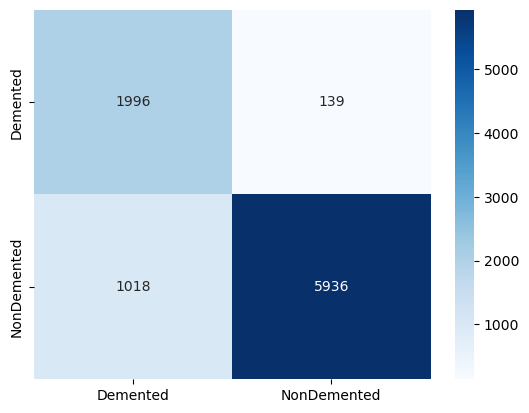

In [529]:
sn.heatmap(df_cm, annot=True, fmt='', cmap='Blues')

Classification Report

In [151]:
print(classification_report(labels, predictions, target_names=class_to_idx))

print(labels)
print(predictions)

NameError: name 'labels' is not defined

In [530]:
def calculate_precision():
    precisions = []
    for row in range(4):
        precisions.append(df_cm[row][row] / (df_cm[0][row] + df_cm[1][row] + df_cm[2][row] + df_cm[3][row]))
    
    total_sum = 0
    overall_precision = 0
    for row in range(4):
        row_sum = 0
        for col in range(4):
            row_sum += df_cm[row][col]
        total_sum += row_sum
        overall_precision += precisions[row] * row_sum
    precisions.append(overall_precision / total_sum)
    return precisions

In [531]:
def calculate_recall():
    recalls = []
    for col in range(4):
        recalls.append(df_cm[col][col] / (df_cm[col][0] + df_cm[col][1] + df_cm[col][2] + df_cm[col][3]))
    
    total_sum = 0
    overall_recall = 0
    for col in range(4):
        col_sum = 0
        for row in range(4):
            col_sum += df_cm[row][col]
        total_sum += col_sum
        overall_recall += recalls[col] * col_sum
    recalls.append(overall_recall / total_sum)
    return recalls

In [532]:
def calculate_f1(precisions, recalls):
    f1_scores = []
    for i in range(5):
        f1_scores[i] = 2 * (precisions[i] * recalls[i]) / (precisions[i] + recalls[i])
    return f1_scores

In [ ]:
import pandas as pd
from tabulate import tabulate

# Data for the table
variables = ['Variable 1', 'Variable 2', 'Variable 3', 'Variable 4', 'Variable 5']
percentages = ['20%', '35%', '15%', '10%', '20%']
data = {'Variables': variables, 'Percentages': percentages}

# Create a pandas DataFrame from the data
df = pd.DataFrame(data)

# Convert the DataFrame to a LaTeX table
table = tabulate(df, headers='keys', tablefmt='latex', showindex=False)

# Print the LaTeX table
print(table)

\begin{tabular}{ll}
\hline
 Variables   & Percentages   \\
\hline
 Variable 1  & 20\%           \\
 Variable 2  & 35\%           \\
 Variable 3  & 15\%           \\
 Variable 4  & 10\%           \\
 Variable 5  & 20\%           \\
\hline
\end{tabular}


In [551]:
def predict_testing_data(model, criterion, device, eval=False):

    ood_dataset = ImageFolder(root='DataOOD', transform= transforms.Compose([transforms.Grayscale()]))
    ood_dataset = CustomDataset(ood_dataset, transform= get_transforms())
    ood_loader = torch.utils.data.DataLoader(ood_dataset, batch_size=hparams.test_batch_size)

    model.eval()
    pred_loss = 0
    pred_correct = 0
    total_size = 0

    predictions = torch.IntTensor()
    ground_truths = torch.IntTensor()

    predictions, ground_truths = predictions.to(device), ground_truths.to(device)
    
    # need this stat
    # count the amount of true positives that were under set confidence level
    true_positive_interference = 0
    total_samples = 0
    real_flagging = 0

    with torch.no_grad():
        for batch_idx, (img, mean, std, target) in enumerate(ood_loader):
            img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
            output = model(img, mean, std)
#             print("pls work",output)
            probs = torch.nn.functional.softmax(output, dim=1)
            conf, classes = torch.max(probs, 1)
            loss = criterion(output, target)
            pred_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)

            
            pred_correct += pred.eq(target.view_as(pred)).sum().item()

            predictions = torch.cat((predictions, pred), dim=0)
            ground_truths = torch.cat((ground_truths, target), dim=0)
            
#             print("End stats: ",conf.size()[0], conf[0].item(), predictions, ground_truths)

#             actually modify the outputs
            j = 0
            while (j < conf.size()[0]):
                if (conf[j].item() < 0.59 and ground_truths[j].item() == 0):
                    # flagged as ood
                    predictions[j] = 2
                    
                j += 1

            # count the false flagging
            j = 0
            while (j < conf.size()[0]):
                if (conf[j].item() < 0.59 and predictions[j].item()==ground_truths[j].item() and ground_truths[j].item() == 0):
                    true_positive_interference += 1
                    pred_correct -= 1
                total_samples += 1
                j += 1
                
#             count the real flagging
#             j = 0
#             while (j < conf.size()[0]):
#                 if (conf[j].item() < 0.59):
#                     real_flagging += 1
#                 total_samples += 1
#                 j += 1
            
            total_size += len(img)
            
            
            #print("Would be flagged ",true_positive_interference/total_samples)

    pred_loss /= total_size
    pred_accuracy = 100. * pred_correct / total_size
    
    print("Flagged",true_positive_interference/total_samples, "of real samples what were supposed to")
#     print("Flagged",real_flagging/total_samples, "of the samples to be flagged")


    if eval:
        return pred_loss, ("ACCURACY"+str(pred_accuracy)), predictions.cpu().numpy(), ground_truths.cpu().numpy()
    else:
        return predictions.cpu().numpy(), ground_truths.cpu().numpy()
    
print(predict_testing_data(model, criterion, device, eval=True))

Flagged 0.0 of real samples what were supposed to
(0.014063821048349948, 'ACCURACY85.13513513513513', array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0]]), array([0

In [538]:
#ood

In [539]:
def extract_features(model, data_loader):
    model.eval()
    all_features = []
    enumerated_data = enumerate(data_loader)
    #print(data_loader.size)
    with torch.no_grad():
        for batch_idx, (img, mean, std, target) in enumerate(data_loader):
            #model(img, mean, std)
            modelres = model(img, mean, std)
            #print(modelres)
            features = model(img, mean, std)
            all_features.append(features.cpu().numpy())
    return np.concatenate(all_features)

In [540]:
def ood_detection_svm(model, svm_model, data_loader):
    model.eval()
    all_features = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.cuda()
            _,features = model(inputs)
            all_features.append(features.cpu().numpy())

    features = np.concatenate(all_features)
    svm_predictions = svm_model.predict(features)
    return svm_predictions

In [541]:
def calculate_confidence(probabilities):
    return torch.tensor([torch.max(probabilities)])
#     return probabilities[0]

def calculate_entropy(probabilities):
    return -np.sum(probabilities * np.log(probabilities), axis=1)

In [460]:
def calculate_confidence_and_entropy(model, data_loader):
    model.eval()
    all_confidences = []
    all_entropies = []

    with torch.no_grad():
        for batch_idx, (img, mean, std, target) in enumerate(data_loader):
#             inputs = inputs.cuda()
            probabilities = model(img, mean, std)
            
#             trypredict = model.predict(img)
#             classification = np.where(trypredict == np.amax(trypredict))[1][0]
            
#             print("Confidence: ",str(trypredict[0][classification]*100))
            probs = torch.nn.functional.softmax(probabilities, dim=1)
            #print("Confidence",probs[0])
            
            
            confidences = calculate_confidence(probs[0])
            print("End confidence",confidences)

                
            entropies = calculate_entropy(probabilities.cpu().numpy())
            all_confidences.extend(confidences)
            all_entropies.extend(entropies)
    return np.array(all_confidences), np.array(all_entropies)

In [284]:
# Extract features for in-distribution test data
in_distribution_features = extract_features(model, test_loader)

# Step 7: Train One-Class SVM model for OOD detection

# svm_model = OneClassSVM(kernel='rbf', nu=0.1)
# svm_model.fit(in_distribution_features)

KeyboardInterrupt: 

In [210]:
print(in_distribution_features)

[[9.8702860e-01 6.6806744e-03 6.2907827e-03]
 [9.9882954e-01 6.0284161e-04 5.6765910e-04]
 [7.0226306e-01 5.8032675e-03 2.9193369e-01]
 ...
 [7.1091659e-02 2.7880598e-02 9.0102774e-01]
 [3.8819991e-03 3.8962935e-03 9.9222165e-01]
 [3.3530714e-03 3.3654214e-03 9.9328148e-01]]


In [461]:
confidence_and_entropy_1 = calculate_confidence_and_entropy(model, test_loader)


End confidence tensor([0.6823])
End confidence tensor([0.5082])
End confidence tensor([0.5844])
End confidence tensor([0.5212])
End confidence tensor([0.6718])
End confidence tensor([0.7142])
End confidence tensor([0.5794])
End confidence tensor([0.6241])
End confidence tensor([0.6065])
End confidence tensor([0.6597])
End confidence tensor([0.6716])
End confidence tensor([0.5334])
End confidence tensor([0.5553])
End confidence tensor([0.5024])
End confidence tensor([0.7005])
End confidence tensor([0.6385])
End confidence tensor([0.5350])
End confidence tensor([0.5645])
End confidence tensor([0.5587])
End confidence tensor([0.6994])
End confidence tensor([0.6011])
End confidence tensor([0.6756])
End confidence tensor([0.5085])
End confidence tensor([0.7283])
End confidence tensor([0.7008])
End confidence tensor([0.5181])
End confidence tensor([0.5357])
End confidence tensor([0.6757])
End confidence tensor([0.6371])
End confidence tensor([0.6353])
End confidence tensor([0.5249])
End conf

/var/folders/st/j3vpdzl95671wq9435lnlf5h0000gn/T/ipykernel_38039/3678755263.py:6: RuntimeWarning: divide by zero encountered in log
  return -np.sum(probabilities * np.log(probabilities), axis=1)
/var/folders/st/j3vpdzl95671wq9435lnlf5h0000gn/T/ipykernel_38039/3678755263.py:6: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(probabilities * np.log(probabilities), axis=1)


End confidence tensor([0.6855])
End confidence tensor([0.5702])
End confidence tensor([0.7302])
End confidence tensor([0.6908])
End confidence tensor([0.7068])
End confidence tensor([0.7257])
End confidence tensor([0.7293])
End confidence tensor([0.6996])
End confidence tensor([0.7295])
End confidence tensor([0.7291])
End confidence tensor([0.6873])
End confidence tensor([0.7269])
End confidence tensor([0.5702])
End confidence tensor([0.7260])
End confidence tensor([0.6985])
End confidence tensor([0.7223])
End confidence tensor([0.6662])
End confidence tensor([0.7269])
End confidence tensor([0.7259])
End confidence tensor([0.6196])
End confidence tensor([0.6761])
End confidence tensor([0.7277])
End confidence tensor([0.6011])
End confidence tensor([0.6255])
End confidence tensor([0.7303])
End confidence tensor([0.5639])
End confidence tensor([0.6166])
End confidence tensor([0.7039])
End confidence tensor([0.7295])
End confidence tensor([0.6563])
End confidence tensor([0.7291])
End conf

In [462]:
print(confidence_and_entropy_1)
# print("mean",np.mean(confidence_and_entropy_1[0]))
# for i in confidence_and_entropy_1:
#     for j in range(i.size):
#         print(i[j])


(array([0.68229824, 0.5081842 , 0.58443725, 0.5211658 , 0.67182994,
       0.7141868 , 0.5794211 , 0.62413037, 0.60651   , 0.65974027,
       0.6715733 , 0.5334403 , 0.5553068 , 0.50243455, 0.7005052 ,
       0.6384546 , 0.5350146 , 0.5645437 , 0.5586995 , 0.69943416,
       0.6010964 , 0.6755505 , 0.508529  , 0.7283403 , 0.7008442 ,
       0.5180803 , 0.53571975, 0.6757365 , 0.63714325, 0.6352996 ,
       0.52493376, 0.6927682 , 0.69818956, 0.5269113 , 0.7227395 ,
       0.7303301 , 0.7278066 , 0.72184086, 0.72618073, 0.70557165,
       0.66573834, 0.69787335, 0.7301002 , 0.6854589 , 0.5701915 ,
       0.7302267 , 0.69082856, 0.7067762 , 0.7256504 , 0.72925574,
       0.69955003, 0.7295124 , 0.729088  , 0.68727785, 0.7269349 ,
       0.5701915 , 0.725995  , 0.6984785 , 0.7222932 , 0.6661609 ,
       0.7268981 , 0.7259055 , 0.61958915, 0.67605853, 0.7276668 ,
       0.6011108 , 0.62554795, 0.7303268 , 0.56391644, 0.616627  ,
       0.70393944, 0.72946775, 0.65634453, 0.7291272 , 0.7299

In [547]:
# Calculate confidence and uncertainty for test data
test_confidences, test_entropies = confidence_and_entropy_1

In [548]:
ood_dataset = ImageFolder(root='DataRandom', transform= transforms.Compose([transforms.Grayscale()]))
ood_dataset = CustomDataset(ood_dataset, transform= get_transforms())
ood_loader = torch.utils.data.DataLoader(ood_dataset, batch_size=hparams.test_batch_size)

# Calculate confidence and uncertainty for out-of-distribution data
ood_confidences, ood_entropies = calculate_confidence_and_entropy(model, ood_loader)

# Print average confidence and uncertainty for test data
print(f"Average Confidence on Test Data: {np.mean(test_confidences):.4f}")
print(f"Average Uncertainty on Test Data: {np.mean(test_entropies):.4f}")

# Print average confidence and uncertainty for out-of-distribution data
print(f"Average Confidence on Out-of-Distribution Data: {np.mean(ood_confidences):.4f}")
print(f"Average Uncertainty on Out-of-Distribution Data: {np.mean(ood_entropies):.4f}")

# Step 10: Evaluate One-Class SVM on in-distribution and out-of-distribution datasets

# Use One-Class SVM to predict OOD samples
svm_in_distribution_predictions = ood_detection_svm(model, svm_model, test_loader)
svm_ood_predictions = ood_detection_svm(model, svm_model, ood_loader)

# Print the number of in-distribution and out-of-distribution samples
print(f"In-distribution samples: {np.sum(svm_in_distribution_predictions == 1)}")
print(f"Out-of-distribution samples: {np.sum(svm_ood_predictions == -1)}")

End confidence tensor([0.6554])
Average Confidence on Test Data: 0.6794
Average Uncertainty on Test Data: nan
Average Confidence on Out-of-Distribution Data: 0.6554
Average Uncertainty on Out-of-Distribution Data: 0.4693


NameError: name 'svm_model' is not defined